In [1]:
!pip install lightgbm joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.5 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve)
from lightgbm import LGBMClassifier

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
project_path = "/content/drive/My Drive/ML project"
os.chdir(project_path)
print("Current working directory:", os.getcwd())
print("\n=== FILES IN PROJECT FOLDER ===")
!ls -l

Current working directory: /content/drive/My Drive/ML project

=== FILES IN PROJECT FOLDER ===
total 3043541
-rw------- 1 root root  668529046 Apr  4 13:38 archive.zip
-rw------- 1 root root     341380 Apr  5 07:51 lgb_model.joblib
-rw------- 1 root root  489567929 Apr  6 10:06 test_dataset.csv
-rw------- 1 root root 1958146989 Apr  6 10:07 train_dataset.csv


In [5]:
def file_exists(filename):
    return os.path.isfile(os.path.join(project_path, filename))

csv_filename = "malicious_urls.csv"
zip_filename = "archive.zip"

if file_exists(csv_filename):
    print(f"\n'{csv_filename}' found.")
    use_combined = True
else:
    print(f"\n'{csv_filename}' NOT found in '{project_path}'.")
    if file_exists(zip_filename):
        print(f"Found '{zip_filename}'. Attempting to unzip...")
        !unzip -o "{os.path.join(project_path, zip_filename)}" -d "{project_path}"
        print("\n=== FILES AFTER UNZIPPING ===")
        !ls -l
    else:
        print(f"No '{zip_filename}' found.")
    if file_exists("train_dataset.csv") and file_exists("test_dataset.csv"):
        print("\nUsing 'train_dataset.csv' and 'test_dataset.csv'.")
        use_combined = False
    else:
        print("\nDataset files not found. Please check your CSV files.")
        use_combined = None


'malicious_urls.csv' NOT found in '/content/drive/My Drive/ML project'.
Found 'archive.zip'. Attempting to unzip...
Archive:  /content/drive/My Drive/ML project/archive.zip
  inflating: /content/drive/My Drive/ML project/test_dataset.csv  
  inflating: /content/drive/My Drive/ML project/train_dataset.csv  

=== FILES AFTER UNZIPPING ===
total 3043541
-rw------- 1 root root  668529046 Apr  4 13:38 archive.zip
-rw------- 1 root root     341380 Apr  5 07:51 lgb_model.joblib
-rw------- 1 root root  489567929 Feb 14  2024 test_dataset.csv
-rw------- 1 root root 1958146989 Feb 14  2024 train_dataset.csv

Using 'train_dataset.csv' and 'test_dataset.csv'.


In [6]:
if use_combined is True:
    try:
        df = pd.read_csv(os.path.join(project_path, csv_filename))
        print(f"\nLoaded '{csv_filename}' successfully!")
    except Exception as e:
        print(f"Error reading '{csv_filename}': {e}")
        df = None
elif use_combined is False:
    try:
        df_train = pd.read_csv(os.path.join(project_path, "train_dataset.csv"))
        df_test  = pd.read_csv(os.path.join(project_path, "test_dataset.csv"))
        print("\nLoaded 'train_dataset.csv' and 'test_dataset.csv' successfully!")
    except Exception as e:
        print("Error loading train/test datasets:", e)
        df_train, df_test = None, None
else:
    df = None



Loaded 'train_dataset.csv' and 'test_dataset.csv' successfully!


In [7]:
drop_cols = ['url', 'source', 'tld']

if use_combined is True and df is not None:
    print("\n=== COMBINED DATASET OVERVIEW ===")
    print("Shape:", df.shape)
    display(df.head())
    print("\nMissing values per column:\n", df.isnull().sum())

    df.dropna(inplace=True)

    for col in drop_cols:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
            print(f"Dropped column: {col}")
elif use_combined is False and df_train is not None and df_test is not None:
    print("\n=== TRAIN DATASET OVERVIEW ===")
    print("Train shape:", df_train.shape)
    display(df_train.head())
    print("\nMissing values in train data:\n", df_train.isnull().sum())
    df_train.dropna(inplace=True)

    print("\n=== TEST DATASET OVERVIEW ===")
    print("Test shape:", df_test.shape)
    display(df_test.head())
    print("\nMissing values in test data:\n", df_test.isnull().sum())
    df_test.dropna(inplace=True)


    for col in drop_cols:
        if col in df_train.columns:
            df_train.drop(col, axis=1, inplace=True)
            print(f"Dropped column from train: {col}")
        if col in df_test.columns:
            df_test.drop(col, axis=1, inplace=True)
            print(f"Dropped column from test: {col}")
else:
    print("\nNo dataset loaded. Exiting the pipeline.")


=== TRAIN DATASET OVERVIEW ===
Train shape: (6728848, 60)


,url,label,source,url_has_login,url_has_client,url_has_server,url_has_admin,url_has_ip,url_isshorted,url_len,...,pdomain_count_hyphen,pdomain_count_atrate,pdomain_count_non_alphanum,pdomain_count_digit,tld_len,tld,tld_is_sus,pdomain_min_distance,subdomain_len,subdomain_count_dot
0,irs-profilepaymentservice.com/home,1,phishtank,0,0,0,0,0,0,34,...,0,0,0,0,3,com,0,17,0,0
1,cpuggsukabumi.id,0,majestic_million,0,0,0,0,0,0,16,...,0,0,0,0,2,id,1,10,0,0
2,members.tripod.com/~don_rc/ring.htm,0,data_clean_test_mendel,0,0,0,0,0,0,35,...,0,0,0,0,3,com,0,2,7,0
3,optuswebmailadminprovider.weebly.com/,1,phishtank,0,0,0,1,0,0,37,...,0,0,0,0,3,com,0,3,25,0
4,topoz.com.pl,0,dmoz_harvard,0,0,0,0,0,0,12,...,0,0,0,0,6,com.pl,0,3,0,0



Missing values in train data:
 url                                    0
label                                  0
source                                 0
url_has_login                          0
url_has_client                         0
url_has_server                         0
url_has_admin                          0
url_has_ip                             0
url_isshorted                          0
url_len                                0
url_entropy                            0
url_hamming_1                          0
url_hamming_00                         0
url_hamming_10                         0
url_hamming_01                         0
url_hamming_11                         0
url_2bentropy                          0
url_3bentropy                          0
url_count_dot                          0
url_count_https                        0
url_count_http                         0
url_count_perc                         0
url_count_hyphen                       0
url_count_www            

,url,label,source,url_has_login,url_has_client,url_has_server,url_has_admin,url_has_ip,url_isshorted,url_len,...,pdomain_count_hyphen,pdomain_count_atrate,pdomain_count_non_alphanum,pdomain_count_digit,tld_len,tld,tld_is_sus,pdomain_min_distance,subdomain_len,subdomain_count_dot
0,spa-security.de,0,dmoz_harvard,0,0,0,0,0,0,15,...,0,0,0,0,2,de,0,7,0,0
1,mallander.de,0,majestic_million,0,0,0,0,0,0,12,...,0,0,0,0,2,de,0,3,0,0
2,zzndb.com.cn,0,alexatop1m,0,0,0,0,0,0,12,...,0,0,0,0,6,com.cn,0,3,0,0
3,enviroseal.com/,0,data_clean_train_mendel,0,0,0,0,0,0,15,...,0,0,0,0,3,com,0,6,0,0
4,hunt1ngtonbank.3utilities.com,1,ALL-phishing-domains,0,0,0,0,0,0,29,...,0,0,0,0,3,com,0,6,14,0



Missing values in test data:
 url                                    0
label                                  0
source                                 0
url_has_login                          0
url_has_client                         0
url_has_server                         0
url_has_admin                          0
url_has_ip                             0
url_isshorted                          0
url_len                                0
url_entropy                            0
url_hamming_1                          0
url_hamming_00                         0
url_hamming_10                         0
url_hamming_01                         0
url_hamming_11                         0
url_2bentropy                          0
url_3bentropy                          0
url_count_dot                          0
url_count_https                        0
url_count_http                         0
url_count_perc                         0
url_count_hyphen                       0
url_count_www             


Train set shape: (6728848, 56) Test set shape: (1682213, 56)

Class Distribution in Training Dataset:
label
0    5283175
1    1445673
Name: count, dtype: int64


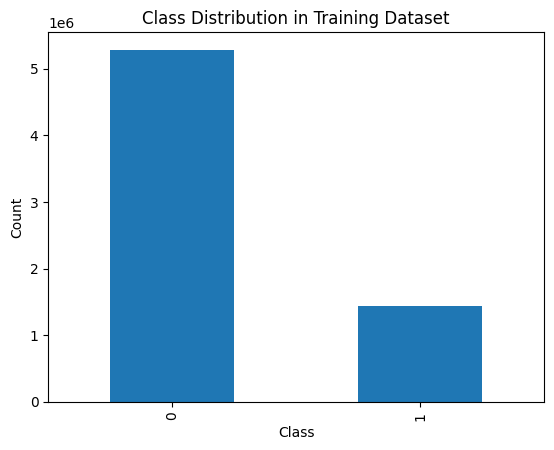

[LightGBM] [Info] Number of positive: 1445673, number of negative: 5283175
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.876151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3979
[LightGBM] [Info] Number of data points in the train set: 6728848, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214847 -> initscore=-1.295952
[LightGBM] [Info] Start training from score -1.295952

=== MODEL PERFORMANCE (Provided Train/Test Data) ===
Accuracy: 0.9308381281086283
Precision: 0.9104102193105851
Recall: 0.752099363896198
F1-Score: 0.8237172931146031

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96   1320794
           1       0.91      0.75      0.82    361419

    accuracy                           0.93   1682213
   macro avg       0.92   

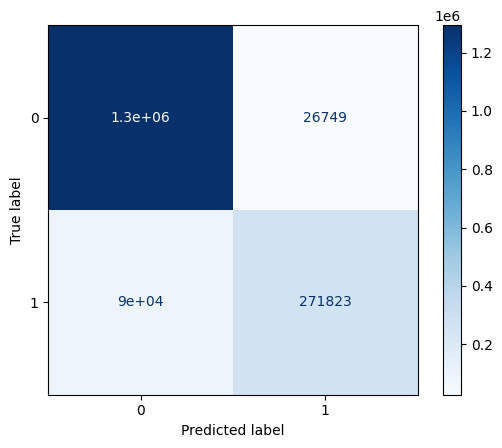

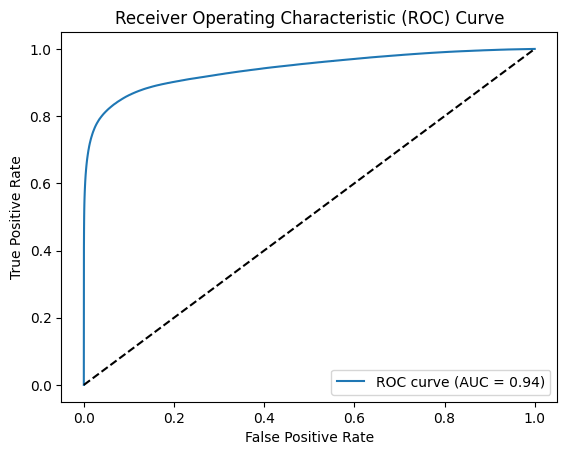

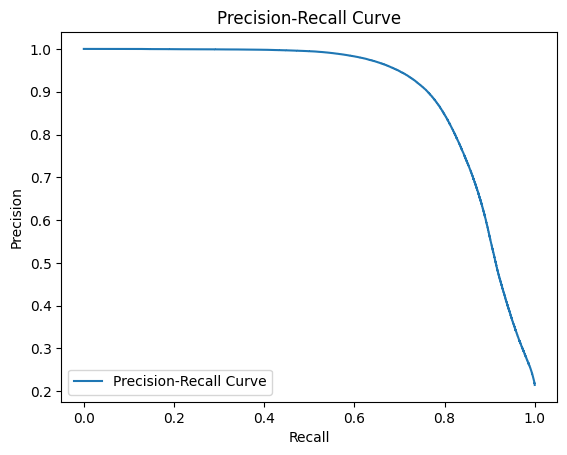

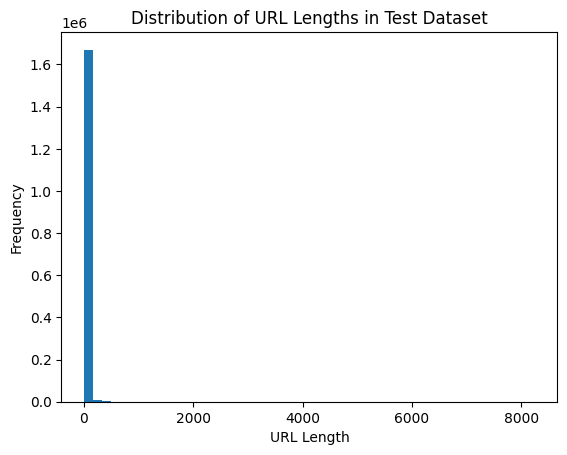

In [8]:
if use_combined is True and df is not None:
    if 'label' not in df.columns:
        print("\nERROR: 'label' column not found in combined dataset.")
    else:
        X = df.drop('label', axis=1)
        y = df['label']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print("\nTrain set shape:", X_train.shape, "Test set shape:", X_test.shape)


        print("\nClass Distribution in Training Dataset:")
        print(y_train.value_counts())
        y_train.value_counts().plot(kind='bar')
        plt.title("Class Distribution in Training Dataset")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.show()


        lgb_model = LGBMClassifier(random_state=42)
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_test)

        print("\n=== MODEL PERFORMANCE (Combined Data Split) ===")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred))
        print("Recall:", recall_score(y_test, y_pred))
        print("F1-Score:", f1_score(y_test, y_pred))


        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.show()


        y_prob = lgb_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.show()


        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        plt.figure()
        plt.plot(recall_vals, precision_vals, label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend(loc="lower left")
        plt.show()


        if "url_len" in X_test.columns:
            plt.figure()
            plt.hist(X_test["url_len"], bins=50)
            plt.title("Distribution of URL Lengths in Test Dataset")
            plt.xlabel("URL Length")
            plt.ylabel("Frequency")
            plt.show()
elif use_combined is False and df_train is not None and df_test is not None:
    if 'label' not in df_train.columns or 'label' not in df_test.columns:
        print("\nERROR: 'label' column not found in train/test datasets.")
    else:
        X_train = df_train.drop('label', axis=1)
        y_train = df_train['label']
        X_test  = df_test.drop('label', axis=1)
        y_test  = df_test['label']
        print("\nTrain set shape:", X_train.shape, "Test set shape:", X_test.shape)


        print("\nClass Distribution in Training Dataset:")
        print(y_train.value_counts())
        y_train.value_counts().plot(kind='bar')
        plt.title("Class Distribution in Training Dataset")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.show()


        lgb_model = LGBMClassifier(random_state=42)
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_test)

        print("\n=== MODEL PERFORMANCE (Provided Train/Test Data) ===")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred))
        print("Recall:", recall_score(y_test, y_pred))
        print("F1-Score:", f1_score(y_test, y_pred))


        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.show()


        y_prob = lgb_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.show()


        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        plt.figure()
        plt.plot(recall_vals, precision_vals, label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend(loc="lower left")
        plt.show()


        if "url_len" in X_test.columns:
            plt.figure()
            plt.hist(X_test["url_len"], bins=50)
            plt.title("Distribution of URL Lengths in Test Dataset")
            plt.xlabel("URL Length")
            plt.ylabel("Frequency")
            plt.show()
else:
    print("\nNo valid dataset available. Please check your file paths and dataset files.")